In [1]:
import os
import math
import csv
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split
import sklearn
from sklearn.utils import shuffle


from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Dropout, Activation
from keras.layers.convolutional import Convolution2D, Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam

%matplotlib inline

Using TensorFlow backend.


In [2]:
samples = []

with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)
    for line in reader:
        samples.append(line)
len(samples)

4544

In [3]:
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

def flip(image, steering):
    image_flipped = np.fliplr(image)
    steering_flipped = -steering
    return image_flipped, steering_flipped 

def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                # create adjusted steering measurements for the side camera images
                correction = 0.2 # this is a parameter to tune
                steering_center = float(batch_sample[3])
                steering_left = steering_center + correction
                steering_right = steering_center - correction
                
                image_path_center = 'data/IMG/' + batch_sample[0].split('/')[-1]
                image_path_left = 'data/IMG/' + batch_sample[1].split('/')[-1]
                image_path_right = 'data/IMG/' + batch_sample[2].split('/')[-1]

                image_center = mpimg.imread(image_path_center)
                image_left = mpimg.imread(image_path_left)
                image_right = mpimg.imread(image_path_right)

                images.append(image_center)
                images.append(image_left)
                images.append(image_right)
                
                angles.append(steering_center)
                angles.append(steering_left)
                angles.append(steering_right)

                #augmentation process, append flipped images
                image_center_flip, steering_center_flip = flip(image_center, steering_center) 
                image_left_flip, steering_left_flip = flip(image_left, steering_left) 
                image_right_flip, steering_right_flip = flip(image_right, steering_right) 

                images.append(image_center_flip)
                images.append(image_left_flip)
                images.append(image_right_flip)
                
                angles.append(steering_center_flip)
                angles.append(steering_left_flip)
                angles.append(steering_right_flip)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)
            
            

In [4]:
# Set our batch size
batch_size=32

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size)
validation_generator = generator(validation_samples, batch_size=batch_size)

In [5]:
model = Sequential()

# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

# trim image to only see section with road
model.add(Cropping2D(cropping=((50,20),(0,0))))           

#layer 1- Convolution, no of filters- 24, filter size= 5x5, stride= 2x2
model.add(Conv2D(24, (5, 5), strides=(2, 2)))
model.add(Activation('elu'))

#layer 2- Convolution, no of filters- 36, filter size= 5x5, stride= 2x2
model.add(Conv2D(36, (5, 5), strides=(2, 2)))
model.add(Activation('elu'))

#layer 3- Convolution, no of filters- 48, filter size= 5x5, stride= 2x2
model.add(Conv2D(48, (5, 5), strides=(2, 2)))
model.add(Activation('elu'))

#layer 4- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))

#layer 5- Convolution, no of filters- 64, filter size= 3x3, stride= 1x1
model.add(Conv2D(64, (3, 3)))
model.add(Activation('elu'))

#flatten image from 2D to side by side
model.add(Flatten())

#layer 6- fully connected layer 1
model.add(Dense(100))
model.add(Activation('elu'))

#Adding a dropout layer to avoid overfitting.
model.add(Dropout(0.25))

#layer 7- fully connected layer 1
model.add(Dense(50))
model.add(Activation('elu'))


#layer 8- fully connected layer 1
model.add(Dense(10))
model.add(Activation('elu'))

#layer 9- fully connected layer 1
model.add(Dense(1))

# the output is the steering angle
# using mean squared error loss function is the right choice for this regression problem
# adam optimizer is used here
model.compile(loss='mse',optimizer='adam')


#fit generator is used here as the number of images are generated by the generator
# no of epochs : 5


history_object  = model.fit_generator(train_generator,
            steps_per_epoch=math.ceil(len(train_samples)/batch_size),
            validation_data=validation_generator,
            validation_steps=math.ceil(len(validation_samples)/batch_size),
            epochs=7, verbose=1)
#saving model
model.save('model.h5')
model.summary()




Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Epoch 1/20





114/114 [==============================] - 112s 983ms/step - loss: 0.1099 - val_loss: 0.0314
Epoch 2/20
114/114 [==============================] - 112s 978ms/step - loss: 0.0272 - val_loss: 0.0282
Epoch 3/20
114/114 [==============================] - 113s 989ms/step - loss: 0.0249 - val_loss: 0.0270
Epoch 4/20
114/114 [==============================] - 112s 979ms/step - loss: 0.0227 - val_loss: 0.0261
Epoch 5/20
114/114 [==============================] - 112s 983ms/step - loss: 0.0209 - val_loss: 0.0255
Epoch 6/20
114/114 [==============================] - 113s 990ms/step - loss: 0.0193 - val_loss: 0.0257
Epoch 7/20
114/114 [==============================] - 111s

dict_keys(['val_loss', 'loss'])


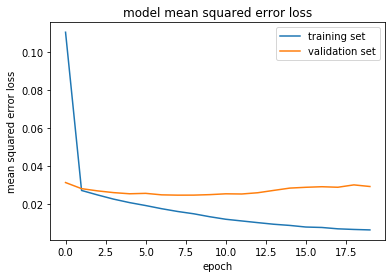

In [6]:
### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()